In [1]:
import tensorflow as tf
import numpy as np
import os
import pickle
import random

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

' اشاره شود که تمامی تمرین ها را من به کمک سرور آزمایشگاه دکتر ربیعی انجام دادم '

' اشاره شود که تمامی تمرین ها را من به کمک سرور آزمایشگاه دکتر ربیعی انجام دادم '

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


data_batch1 = unpickle('../Ehsan/Dataset/HW2/cifar-10-batches-py/data_batch_1')
data_batch2 = unpickle('../Ehsan/Dataset/HW2/cifar-10-batches-py/data_batch_2')
data_batch3 = unpickle('../Ehsan/Dataset/HW2/cifar-10-batches-py/data_batch_3')
data_batch4 = unpickle('../Ehsan/Dataset/HW2/cifar-10-batches-py/data_batch_4')
data_batch5 = unpickle('../Ehsan/Dataset/HW2/cifar-10-batches-py/data_batch_5')
data_test = unpickle('../Ehsan/Dataset/HW2/cifar-10-batches-py/test_batch')

train_x = np.concatenate((data_batch1[b'data'],
                                    data_batch2[b'data'],
                                    data_batch3[b'data'],
                                    data_batch4[b'data'],
                                    data_batch5[b'data'],), axis=0)
train_y = np.concatenate((data_batch1[b'labels']
                              , data_batch2[b'labels']
                              , data_batch3[b'labels']
                              , data_batch4[b'labels']
                              , data_batch5[b'labels'],), axis=0)

test_x = data_test[b'data']
test_y = np.array(data_test[b'labels'])
del data_batch1, data_batch2, data_batch3, data_batch4, data_batch5, data_test

In [3]:
train_x = np.array(train_x)
train_x = np.reshape(train_x, (50000, 3, 32, 32))
train_x = np.transpose(train_x, (0, 2, 3, 1))

test_x = np.array(test_x)
test_x = np.reshape(test_x, (10000, 3, 32, 32))
test_x = np.transpose(test_x, (0, 2, 3, 1))

train_y = np.array(train_y)
train_y = np.reshape(train_y, (50000, 1))

test_y = np.array(test_y)
test_y = np.reshape(test_y, (10000, 1))

In [4]:
print(test_y[50])

[9]


In [5]:
def to_one_hat(y):
    o = np.zeros((len(y), 10))
    for i in range(len(y)):
        o[i][y[i] - 1] = 1
    return o

test_y = to_one_hat(test_y)
train_y = to_one_hat(train_y)

In [6]:
print(train_x[2].shape)

(32, 32, 3)


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


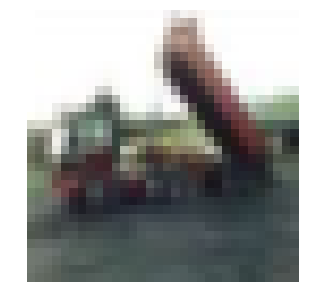

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(figsize=(5,5))

axs.set_axis_off()
axs.imshow(train_x[2], )
print(train_y[2])
plt.show()

In [26]:
learning_rate = 0.00005

conv_filter_size = 5

conv_stride_size = 1
conv_layers = 64

pool_filter_size = 3
pool_stride_size = 2

fc1_size = 512


X = tf.placeholder(tf.float32, [None, 32, 32, 3], name='X_placeholder')
Y = tf.placeholder(tf.float32, [None, 10], name='Y_placeholder')

conv1_filter = tf.Variable(tf.random_normal([conv_filter_size, conv_filter_size, 3, conv_layers], name = "conv1_filter"))
bias_conv1 = tf.Variable(tf.fill([conv_layers], 0.01, name = "bias_conv1"))
conv1 = tf.nn.conv2d(X, 
                    conv1_filter,
                    strides = [1, conv_stride_size, conv_stride_size, 1], 
                     padding="SAME", 
                     name = "conv1") + bias_conv1

conv1_relu = tf.nn.relu(conv1, name = "conv1_relu")
pool1 = tf.nn.max_pool(conv1_relu,
                      ksize = [1, pool_filter_size, pool_filter_size, 1],
                      strides = [1, pool_stride_size, pool_stride_size, 1],
                       padding="SAME",
                       name = "pool1")


conv2_filter = tf.Variable(tf.random_normal([conv_filter_size, conv_filter_size, conv_layers, conv_layers], name = "conv2_filter"))
bias_conv2 = tf.Variable(tf.fill([conv_layers], 0.01, name = "bias_conv2"))
conv2 = tf.nn.conv2d(pool1, 
                    conv2_filter,
                    strides = [1, conv_stride_size, conv_stride_size, 1],
                    padding="SAME",
                    name = "conv2") + bias_conv2

conv2_relu = tf.nn.relu(conv2, "conv2_relu")
pool2 = tf.nn.max_pool(conv2_relu,
                      ksize = [1, pool_filter_size, pool_filter_size, 1],
                      strides = [1, pool_stride_size, pool_stride_size, 1],
                      padding="SAME"
                      )

pool2 = tf.reshape(pool2, (-1, 4096), name = "pool2")

def fullLayer(input_data, output_size, act, name):
    w = tf.Variable(tf.random_normal([input_data.get_shape().as_list()[1], output_size], stddev = 0.2), name = name + "weigth")
    b = tf.Variable(tf.random_normal([output_size], stddev = 0.2), name = name+ "bias")
    return act(tf.matmul(input_data, w) + b , name = name)

fc1 = fullLayer(pool2, fc1_size, tf.nn.relu, "fc1")
fc2 = fullLayer(fc1, 10, tf.identity, "fc2")

pred = tf.nn.softmax(fc2, name = "predications")

##check how many of them are correct arg maxx is used because Y is one hat
correct_preds = tf.equal(tf.argmax(fc2, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=Y, name='loss')

loss = tf.reduce_mean(entropy, name = "loss") 

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)



In [27]:
##just some config for not getting whole server
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)
sess =  tf.Session(config = config) 
    
num_epochs = 30
batch_size = 50

##initialize the variables
sess.run(tf.global_variables_initializer())

n_batches = 50000 // batch_size
for i in range(num_epochs):
    total_loss = 0
    total_acc = 0
    
    conc = list(zip(train_x, train_y))
    random.shuffle(conc)
    train_x, train_y = zip(*conc)
    
    for j in range(n_batches):
        X_batch, Y_batch = train_x[j * batch_size:(j+1) * batch_size], train_y[j * batch_size:(j+1) * batch_size]
        _, loss_batch, acc_batch = sess.run([optimizer, loss, accuracy], feed_dict={X: X_batch, Y: Y_batch})

        total_loss += loss_batch
        total_acc += acc_batch


    print('step {}, Avereage Loss :{}, Accuracy : {:.6f}'.format( (i+1) * n_batches, total_loss / n_batches,  total_acc / n_batches ))




step 1000, Avereage Loss :258265.131265625, Accuracy : 0.241600
step 2000, Avereage Loss :136638.4595703125, Accuracy : 0.322060
step 3000, Avereage Loss :111074.36673046876, Accuracy : 0.357380
step 4000, Avereage Loss :95063.83709375, Accuracy : 0.380720
step 5000, Avereage Loss :84431.97319921874, Accuracy : 0.399700
step 6000, Avereage Loss :75843.83893359375, Accuracy : 0.418520
step 7000, Avereage Loss :69243.3822421875, Accuracy : 0.430920
step 8000, Avereage Loss :63744.264390625, Accuracy : 0.445960
step 9000, Avereage Loss :58872.39362109375, Accuracy : 0.457200
step 10000, Avereage Loss :54785.97907421875, Accuracy : 0.470300
step 11000, Avereage Loss :51236.704130859376, Accuracy : 0.480380
step 12000, Avereage Loss :47868.43945507812, Accuracy : 0.491360
step 13000, Avereage Loss :44947.928681640624, Accuracy : 0.502320
step 14000, Avereage Loss :42437.04086914063, Accuracy : 0.507480
step 15000, Avereage Loss :39987.266815429684, Accuracy : 0.519460
step 16000, Avereage L

In [ ]:
'''
نکته ای که باید اشاره کنم این است که من لرنینگ ریت ها و تابع اکتیویشن ها و استاندارد دوییشن های متفاوتی برای مقدار گذاری اولیه ی 
لایه های فولی کانکتد امتحان کردم
'''

In [28]:
n_batches = 10000 // batch_size
total_correct_preds = 0
for i in range(n_batches):
    ## test batches
    X_batch, Y_batch = test_x[i * batch_size:(i+1) * batch_size], test_y[i * batch_size:(i+1) * batch_size]
    accuracy_batch  = sess.run([accuracy, ], feed_dict={X: X_batch, Y: Y_batch})


    total_correct_preds += accuracy_batch[0]
print('test Accuracy , {}'.format(total_correct_preds / n_batches ))

test Accuracy , 0.5078999841213226


In [30]:
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
saver = tf.train.Saver()
saver.save(sess, 'Models/Model-{}'.format(date))

'Models/Model-2017-11-05-22-07'

In [31]:
filter1, filter2 = sess.run([conv1_filter, conv2_filter])

In [32]:
print(filter1.shape)

(5, 5, 3, 64)


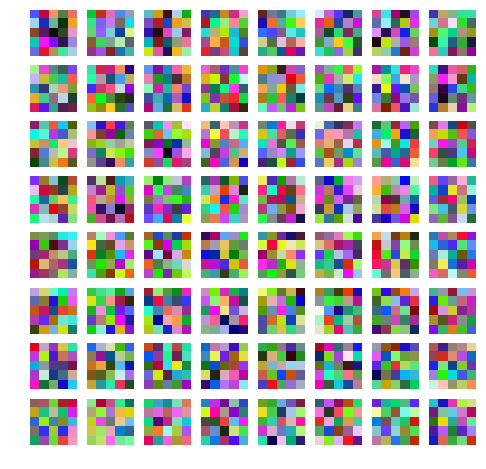

'\nاین کل فیلتر لایه ی اول است\n'

In [43]:
fig, axs = plt.subplots(8,8, figsize = (8, 8))
for i in range(8):
    for j in range(8):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(filter1[:,: , :,i * 8 + j], )


plt.show()
'''
این کل فیلتر لایه ی اول است
'''

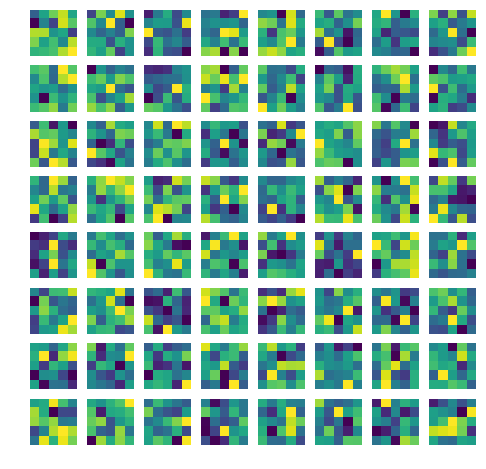

'\nاین میانگین فیلتر های لایه ی دوم است\n'

In [38]:
fig, axs = plt.subplots(8,8, figsize = (8,8))
for i in range(8):
    for j in range(8):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(np.mean(filter2[:,: , :,i * 8 + j],axis =2))


plt.show()
'''
این میانگین فیلتر های لایه ی دوم است
'''

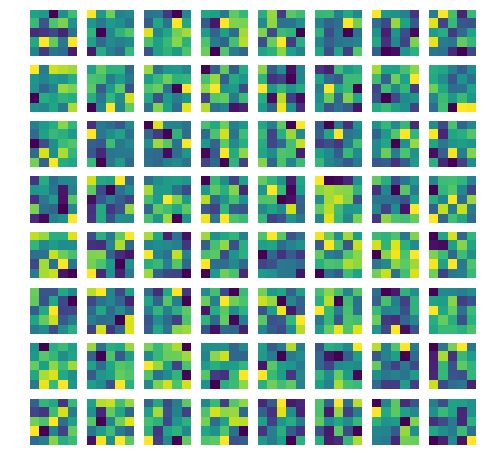

'\nاین میانگین فیلتر های لایه ی یکی از است\n'

In [39]:
fig, axs = plt.subplots(8,8, figsize = (8,8))
for i in range(8):
    for j in range(8):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(filter2[:,: , 0,i * 8 + j])


plt.show()
'''
این میانگین فیلتر های لایه ی یکی از است
'''

In [ ]:
'''
فیلتر های لایه اول منطقی بود که چیز های ساده مثل خط را تشخیص دهد
مثل لبه یا رنگ ولی خب جای مشخصی که همه همرنگ باشند پیدا نکردم
لایه های بالاتر هم باید چیز های پبچبده تری نشان می دادند
ولی برای آن ها هم پیزی مشخص نیست
'''

In [44]:
sess.close()

In [45]:
data = np.load('../Ehsan/Dataset/HW2/cifar_0_29.npy').item()

In [46]:
x = np.array(data['data'])
x = np.reshape(x, (1200, 3, 32, 32))
x = np.transpose(x, (0, 2, 3, 1))
y = np.array(data['labels'])
y = np.reshape(y, [1200, 1])
train_x = x[:1000]
train_y = y[:1000]
test_x = x[1000:]
test_y = y[1000:]

In [47]:
def to_one_hat(y):
    o = np.zeros((len(y), 2))
    for i in range(len(y)):
        o[i][y[i] - 1] = 1
    return o

test_y = to_one_hat(test_y)
train_y = to_one_hat(train_y)

In [48]:
ses = tf.Session()
saver = tf.train.import_meta_graph('Models/Model-2017-11-05-22-07.meta')
saver.restore(ses,tf.train.latest_checkpoint('Models/.'))

INFO:tensorflow:Restoring parameters from Models/./Model-2017-11-05-22-07


In [49]:
conv1_filter_v1, conv2_filter_v1 = ses.run(["conv1_filter:0", "conv2_filter:0"])
'''
تنها چیزی که از شبکه ی قبلی لازم است برداریم همین است زیرا مکس پول که پارامتری ندارد و بقیه ی چیز ها ثابت است
'''

In [50]:
print(conv1_filter_v1)

[[[[ 0.66996729  0.66795802 -0.16982313 ...,  0.43888891  1.24968183
    -0.33559933]
   [ 0.14838196  2.10361409  0.31219965 ..., -0.2023816   0.64850134
     0.63212764]
   [-0.13794193  0.87304664 -0.13871939 ..., -0.19375172 -0.36161172
     2.47820139]]

  [[-0.51326674 -2.62735677  0.60100108 ..., -0.34853855 -0.04866505
     0.70277184]
   [-0.25661087  1.46566403 -0.16003683 ...,  1.29998446  1.9607507
    -1.135921  ]
   [ 0.21266921  1.38885808  1.54226744 ...,  0.62166023  0.49093598
     1.59687567]]

  [[-0.81894398  0.24457811 -1.21814001 ...,  1.57684994  0.33029401
    -0.35818693]
   [ 0.01183102  0.5695551   0.27856123 ..., -1.0723846  -0.15918285
     1.34488106]
   [ 1.4593178   0.89695072  1.61908817 ..., -1.23993695  0.30601177
    -0.00790482]]

  [[-0.73831284  0.31524047 -1.0760442  ...,  1.80274868  1.75575256
    -0.27049631]
   [ 0.33862823  0.76851058  0.15522565 ..., -1.04843879  0.10011356
    -0.36508298]
   [ 0.50561863  0.12264922  0.46623608 ...,  0.8

In [57]:
learning_rate = 0.05

conv_filter_size = 5

conv_stride_size = 1
conv_layers = 64

pool_filter_size = 3
pool_stride_size = 2

fc1_size = 512

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3], name='X_placeholder')
Y = tf.placeholder(tf.float32, [None, 2], name='Y_placeholder')


bias_conv1_v2 = tf.Variable(tf.fill([conv_layers], 0.01, name = "bias_conv1_v2"))
conv1_v2 = tf.nn.conv2d(X, 
                    conv1_filter_v1,
                    strides = [1, conv_stride_size, conv_stride_size, 1], 
                     padding="SAME", 
                     name = "conv1_v2") + bias_conv1_v2

conv1_relu_v2 = tf.nn.relu(conv1_v2, name = "conv1_relu_v2")
pool1_v2 = tf.nn.max_pool(conv1_relu_v2,
                      ksize = [1, pool_filter_size, pool_filter_size, 1],
                      strides = [1, pool_stride_size, pool_stride_size, 1],
                       padding="SAME",
                       name = "pool1_v2")


bias_conv2_v2 = tf.Variable(tf.fill([conv_layers], 0.01, name = "bias_conv2_v2"))
conv2_v2 = tf.nn.conv2d(pool1_v2, 
                    conv2_filter_v1,
                    strides = [1, conv_stride_size, conv_stride_size, 1],
                    padding="SAME",
                    name = "conv2_v2") + bias_conv2_v2

conv2_relu_v2 = tf.nn.relu(conv2_v2, "conv2_relu_v2")
pool2_v2 = tf.nn.max_pool(conv2_relu_v2,
                      ksize = [1, pool_filter_size, pool_filter_size, 1],
                      strides = [1, pool_stride_size, pool_stride_size, 1],
                      padding="SAME"
                      )

pool2_v2 = tf.reshape(pool2_v2, (-1, 4096), name = "pool2_v2")

def fullLayer(input_data, output_size, act, name):
    w = tf.Variable(tf.random_normal([input_data.get_shape().as_list()[1], output_size]), name = name + "weigth")
    b = tf.Variable(tf.random_normal([output_size]), name = name+ "bias")
    return act(tf.matmul(input_data, w) + b , name = name)

fc1_v2 = fullLayer(pool2_v2, fc1_size, tf.nn.relu, "fc1_v2")
fc2_v2 = fullLayer(fc1_v2, 2, tf.identity, "fc2_v2")

pred = tf.nn.softmax(fc2_v2, name = "predications")

##check how many of them are correct arg maxx is used because Y is one hat
correct_preds = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2_v2, labels=Y, name='loss_v2')

loss = tf.reduce_mean(entropy, name = "loss_v2") 

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)



In [58]:
##just some config for not getting whole server
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)
sess =  tf.Session(config = config) 
    
num_epochs = 20
batch_size = 50

##initialize the variables
sess.run(tf.global_variables_initializer())

n_batches = 1000 // batch_size
for i in range(num_epochs):
    total_loss = 0
    total_acc = 0
    
    conc = list(zip(train_x, train_y))
    random.shuffle(conc)
    train_x, train_y = zip(*conc)
    
    for j in range(n_batches):
        X_batch, Y_batch = train_x[j * batch_size:(j+1) * batch_size], train_y[j * batch_size:(j+1) * batch_size]
        _, loss_batch, acc_batch, p = sess.run([optimizer, loss, accuracy, fc2_v2], feed_dict={X: X_batch, Y: Y_batch})

        total_loss += loss_batch
        total_acc += acc_batch
        

    print('step {}, Avereage Loss :{}, Accuracy : {:.6f}'.format( (i+1) * n_batches, total_loss / n_batches,  total_acc / n_batches ))




step 20, Avereage Loss :150622474.84375, Accuracy : 0.522000
step 40, Avereage Loss :3763618.21875, Accuracy : 0.730000
step 60, Avereage Loss :1435542.375, Accuracy : 0.844000
step 80, Avereage Loss :664508.32578125, Accuracy : 0.877000
step 100, Avereage Loss :436200.549609375, Accuracy : 0.894000
step 120, Avereage Loss :608957.5984863281, Accuracy : 0.870000
step 140, Avereage Loss :403502.2416259766, Accuracy : 0.890000
step 160, Avereage Loss :240856.167578125, Accuracy : 0.919000
step 180, Avereage Loss :338517.21479492186, Accuracy : 0.908000
step 200, Avereage Loss :274904.69851074216, Accuracy : 0.914000
step 220, Avereage Loss :657920.544140625, Accuracy : 0.857000
step 240, Avereage Loss :585033.0892578125, Accuracy : 0.884000
step 260, Avereage Loss :377042.15477294923, Accuracy : 0.895000
step 280, Avereage Loss :214172.952734375, Accuracy : 0.918000
step 300, Avereage Loss :102835.16357421875, Accuracy : 0.959000
step 320, Avereage Loss :185141.91923828126, Accuracy : 0.

In [59]:
n_batches = 200 // batch_size
total_correct_preds = 0
for i in range(n_batches):
    ## test batches
    X_batch, Y_batch = test_x[i * batch_size:(i+1) * batch_size], test_y[i * batch_size:(i+1) * batch_size]
    accuracy_batch  = sess.run([accuracy, ], feed_dict={X: X_batch, Y: Y_batch})


    total_correct_preds += accuracy_batch[0]
print('test Accuracy , {}'.format(total_correct_preds / n_batches ))
'''
همانطور که میبینید با فیلتر شبکه ی قبلی به اکیوریسی 93 درصد رسیدیم
'''

test Accuracy , 0.9300000071525574


'\nهمانطور که میبینید با فیلتر شبکه ی قبلی به اکیوریسی 78 درصد رسیدیم\n'